# Terphenyl Heteropolymer Analysis Notebook

In this notebook I will perform several data analysis on the RHH terphenyl octamer. This molecule has 3 aromatic moieties connected with peptide-linkers. Collaborators in the Gellman group, at U Wisc-Ma., have been trying to synthesize and characterize this molecule. This would represent a novel type of foldamer molecule.

## Replica Exchange Energy Distributions

For replica exchange data, it is imporant to see the overlap of energy states from each replica. For this reason we will look at the histogram of energies from each simulation and confirm that energies each replica is behaving as expected.

In [1]:
import panedr
import matplotlib.pyplot as plt
import numpy as np
import os
import pymbar
from scipy.constants import physical_constants, find

plt.style.use('ggplot')

In [2]:
energy_df = panedr.edr_to_df("../sim0/npt.edr")
energy_df.head()

,Time,Bond,Angle,Proper Dih.,LJ-14,Coulomb-14,LJ (SR),Disper. corr.,Coulomb (SR),Coul. recip.,...,Pres-YZ,Pres-ZX,Pres-ZY,Pres-ZZ,#Surf*SurfTen,Box-Vel-XX,Box-Vel-YY,Box-Vel-ZZ,T-System,Lamb-System
0.0,0.0,3821.400879,15195.199219,515.260437,591.994446,-1047.726929,1063.418091,-28.662003,-5275.471191,1292.465820,...,115.141861,347.244385,115.143845,176.696198,615.206055,0.000000,0.000000,0.000000,226.623932,1.0
100.0,100.0,3951.689697,14925.915039,493.858887,582.200317,-1057.283936,-24041.978516,-10.134899,-4304.611328,302.315979,...,167.786377,105.012726,167.786377,368.049103,-1063.313721,0.000116,0.000116,0.000116,226.282211,1.0
200.0,200.0,3756.028809,15100.609375,495.191223,623.182983,-1056.179810,-23884.673828,-10.070463,-4301.423340,353.991455,...,48.791668,-49.580032,48.792316,348.390808,2802.044678,-0.002121,-0.002121,-0.002121,226.030457,1.0
300.0,300.0,3997.822266,15091.799805,504.088470,599.458862,-1050.571289,-24100.880859,-10.120700,-4341.618652,328.393677,...,-19.702532,373.134125,-19.701366,31.240614,726.304626,0.001995,0.001995,0.001995,223.546173,1.0
400.0,400.0,3760.550781,15026.639648,522.764282,570.192627,-1057.086914,-23996.125000,-10.100462,-4421.774414,332.130920,...,-4.289162,78.835785,-4.288706,482.891907,2405.204102,0.002528,0.002528,0.002528,225.371780,1.0


In [3]:
energy_df.keys()

Index(['Time', 'Bond', 'Angle', 'Proper Dih.', 'LJ-14', 'Coulomb-14',
       'LJ (SR)', 'Disper. corr.', 'Coulomb (SR)', 'Coul. recip.', 'LJ recip.',
       'Potential', 'Kinetic En.', 'Total Energy', 'Conserved En.',
       'Temperature', 'Pres. DC', 'Pressure', 'Constr. rmsd', 'Box-X', 'Box-Y',
       'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy', 'Vir-XX', 'Vir-XY',
       'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY', 'Vir-ZZ',
       'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY', 'Pres-YZ',
       'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen', 'Box-Vel-XX',
       'Box-Vel-YY', 'Box-Vel-ZZ', 'T-System', 'Lamb-System'],
      dtype='object')

In [4]:
# Extract Potential Energies from each simulation
sim_dir_name = "sim"
path = "../"
n_replicas = 20

temps = []
energies = []
for i in range(n_replicas):
    sim_dir = os.path.join(path, sim_dir_name + str(i))
    T = None
    print(os.path.join(sim_dir, "npt.mdp"))
    with open(os.path.join(sim_dir, "npt.mdp"), "r")as f:
        for line in f.readlines():
            if "ref-t" in line:
                T = float(line.split()[-1])
                temps.append(T)
    sim_energies = []
    for file in os.listdir(sim_dir):
        if file.endswith(".edr"):
            edr_file = os.path.join(sim_dir, file)
            energy_df = panedr.edr_to_df(edr_file)
            pot_energy = energy_df["Potential"].values
            sim_energies += list(pot_energy)
            print("First Energy:", pot_energy[0])
            print("Last Energy:", pot_energy[-1])
    sim_energies = np.array(sim_energies)
    energies.append(sim_energies)

../sim0/npt.mdp
First Energy: -22852.470703125
Last Energy: -22333.955078125
First Energy: -22962.365234375
Last Energy: -22888.1640625
First Energy: -22587.36328125
Last Energy: -21947.734375
First Energy: -23161.244140625
Last Energy: -23021.2265625
First Energy: -22898.5234375
Last Energy: -22870.203125
First Energy: -22520.625
Last Energy: -22486.5078125
First Energy: -21951.224609375
Last Energy: -22896.412109375
First Energy: -22745.255859375
Last Energy: -22924.353515625
First Energy: -22891.75
Last Energy: -22876.017578125
First Energy: -22595.54296875
Last Energy: -22848.978515625
First Energy: -22879.5703125
Last Energy: -22517.0546875
First Energy: -32020.4609375
Last Energy: -22613.07421875
First Energy: -22927.783203125
Last Energy: -22501.662109375
First Energy: -22578.361328125
Last Energy: -22592.048828125
First Energy: -22768.6796875
Last Energy: -22574.77734375
First Energy: -22636.291015625
Last Energy: -22855.943359375
First Energy: -22629.009765625
Last Energy: -22

First Energy: -20230.0
Last Energy: -19797.873046875
First Energy: -19755.982421875
Last Energy: -20226.626953125
First Energy: -19788.41015625
Last Energy: -20069.404296875
First Energy: -19885.642578125
Last Energy: -19846.1640625
First Energy: -20097.103515625
Last Energy: -19882.564453125
First Energy: -20086.47265625
Last Energy: -19773.84375
First Energy: -20057.439453125
Last Energy: -19833.6015625
First Energy: -19721.935546875
Last Energy: -20055.80078125
First Energy: -19756.845703125
Last Energy: -20121.533203125
First Energy: -20072.802734375
Last Energy: -19999.263671875
First Energy: -19777.060546875
Last Energy: -19752.759765625
First Energy: -20329.451171875
Last Energy: -19806.396484375
../sim6/npt.mdp
First Energy: -19966.9375
Last Energy: -19356.1796875
First Energy: -19492.123046875
Last Energy: -19573.12890625
First Energy: -19559.080078125
Last Energy: -19262.75
First Energy: -19415.2578125
Last Energy: -19218.328125
First Energy: -19541.330078125
Last Energy: -18

First Energy: -16717.591796875
Last Energy: -16544.638671875
First Energy: -16482.09375
Last Energy: -15912.1494140625
First Energy: -16419.66015625
Last Energy: -16364.84375
First Energy: -16165.138671875
Last Energy: -16383.3427734375
First Energy: -16547.810546875
Last Energy: -16607.73828125
First Energy: -15806.91796875
Last Energy: -16374.5029296875
First Energy: -16916.1796875
Last Energy: -16975.6328125
First Energy: -16520.9609375
Last Energy: -15798.3408203125
First Energy: -16978.66015625
Last Energy: -16162.3896484375
First Energy: -32020.462890625
Last Energy: -16121.8876953125
First Energy: -16377.55078125
Last Energy: -16195.556640625
First Energy: -16340.681640625
Last Energy: -16517.955078125
First Energy: -16448.017578125
Last Energy: -16337.4140625
First Energy: -16896.171875
Last Energy: -16523.240234375
First Energy: -16271.431640625
Last Energy: -15803.962890625
First Energy: -15915.1171875
Last Energy: -16268.3369140625
First Energy: -16610.76171875
Last Energy: 

First Energy: -32020.462890625
Last Energy: -12786.373046875
First Energy: -12601.986328125
Last Energy: -13044.12890625
First Energy: -13272.0634765625
Last Energy: -13177.37109375
First Energy: -13150.4521484375
Last Energy: -13269.4765625
First Energy: -13081.1171875
Last Energy: -13115.91015625
First Energy: -13240.169921875
Last Energy: -12848.8466796875
First Energy: -13236.375
Last Energy: -13237.490234375
First Energy: -13074.404296875
Last Energy: -13456.4443359375
First Energy: -12698.935546875
Last Energy: -13412.6015625
First Energy: -13331.1728515625
Last Energy: -12696.3642578125
First Energy: -13046.90625
Last Energy: -12834.0810546875
First Energy: -13118.7119140625
Last Energy: -12976.1865234375
First Energy: -13459.2373046875
Last Energy: -13147.6298828125
First Energy: -12733.7900390625
Last Energy: -12509.5390625
../sim17/npt.mdp
First Energy: -12108.8056640625
Last Energy: -12366.3544921875
First Energy: -11972.1416015625
Last Energy: -12172.9931640625
First Energy

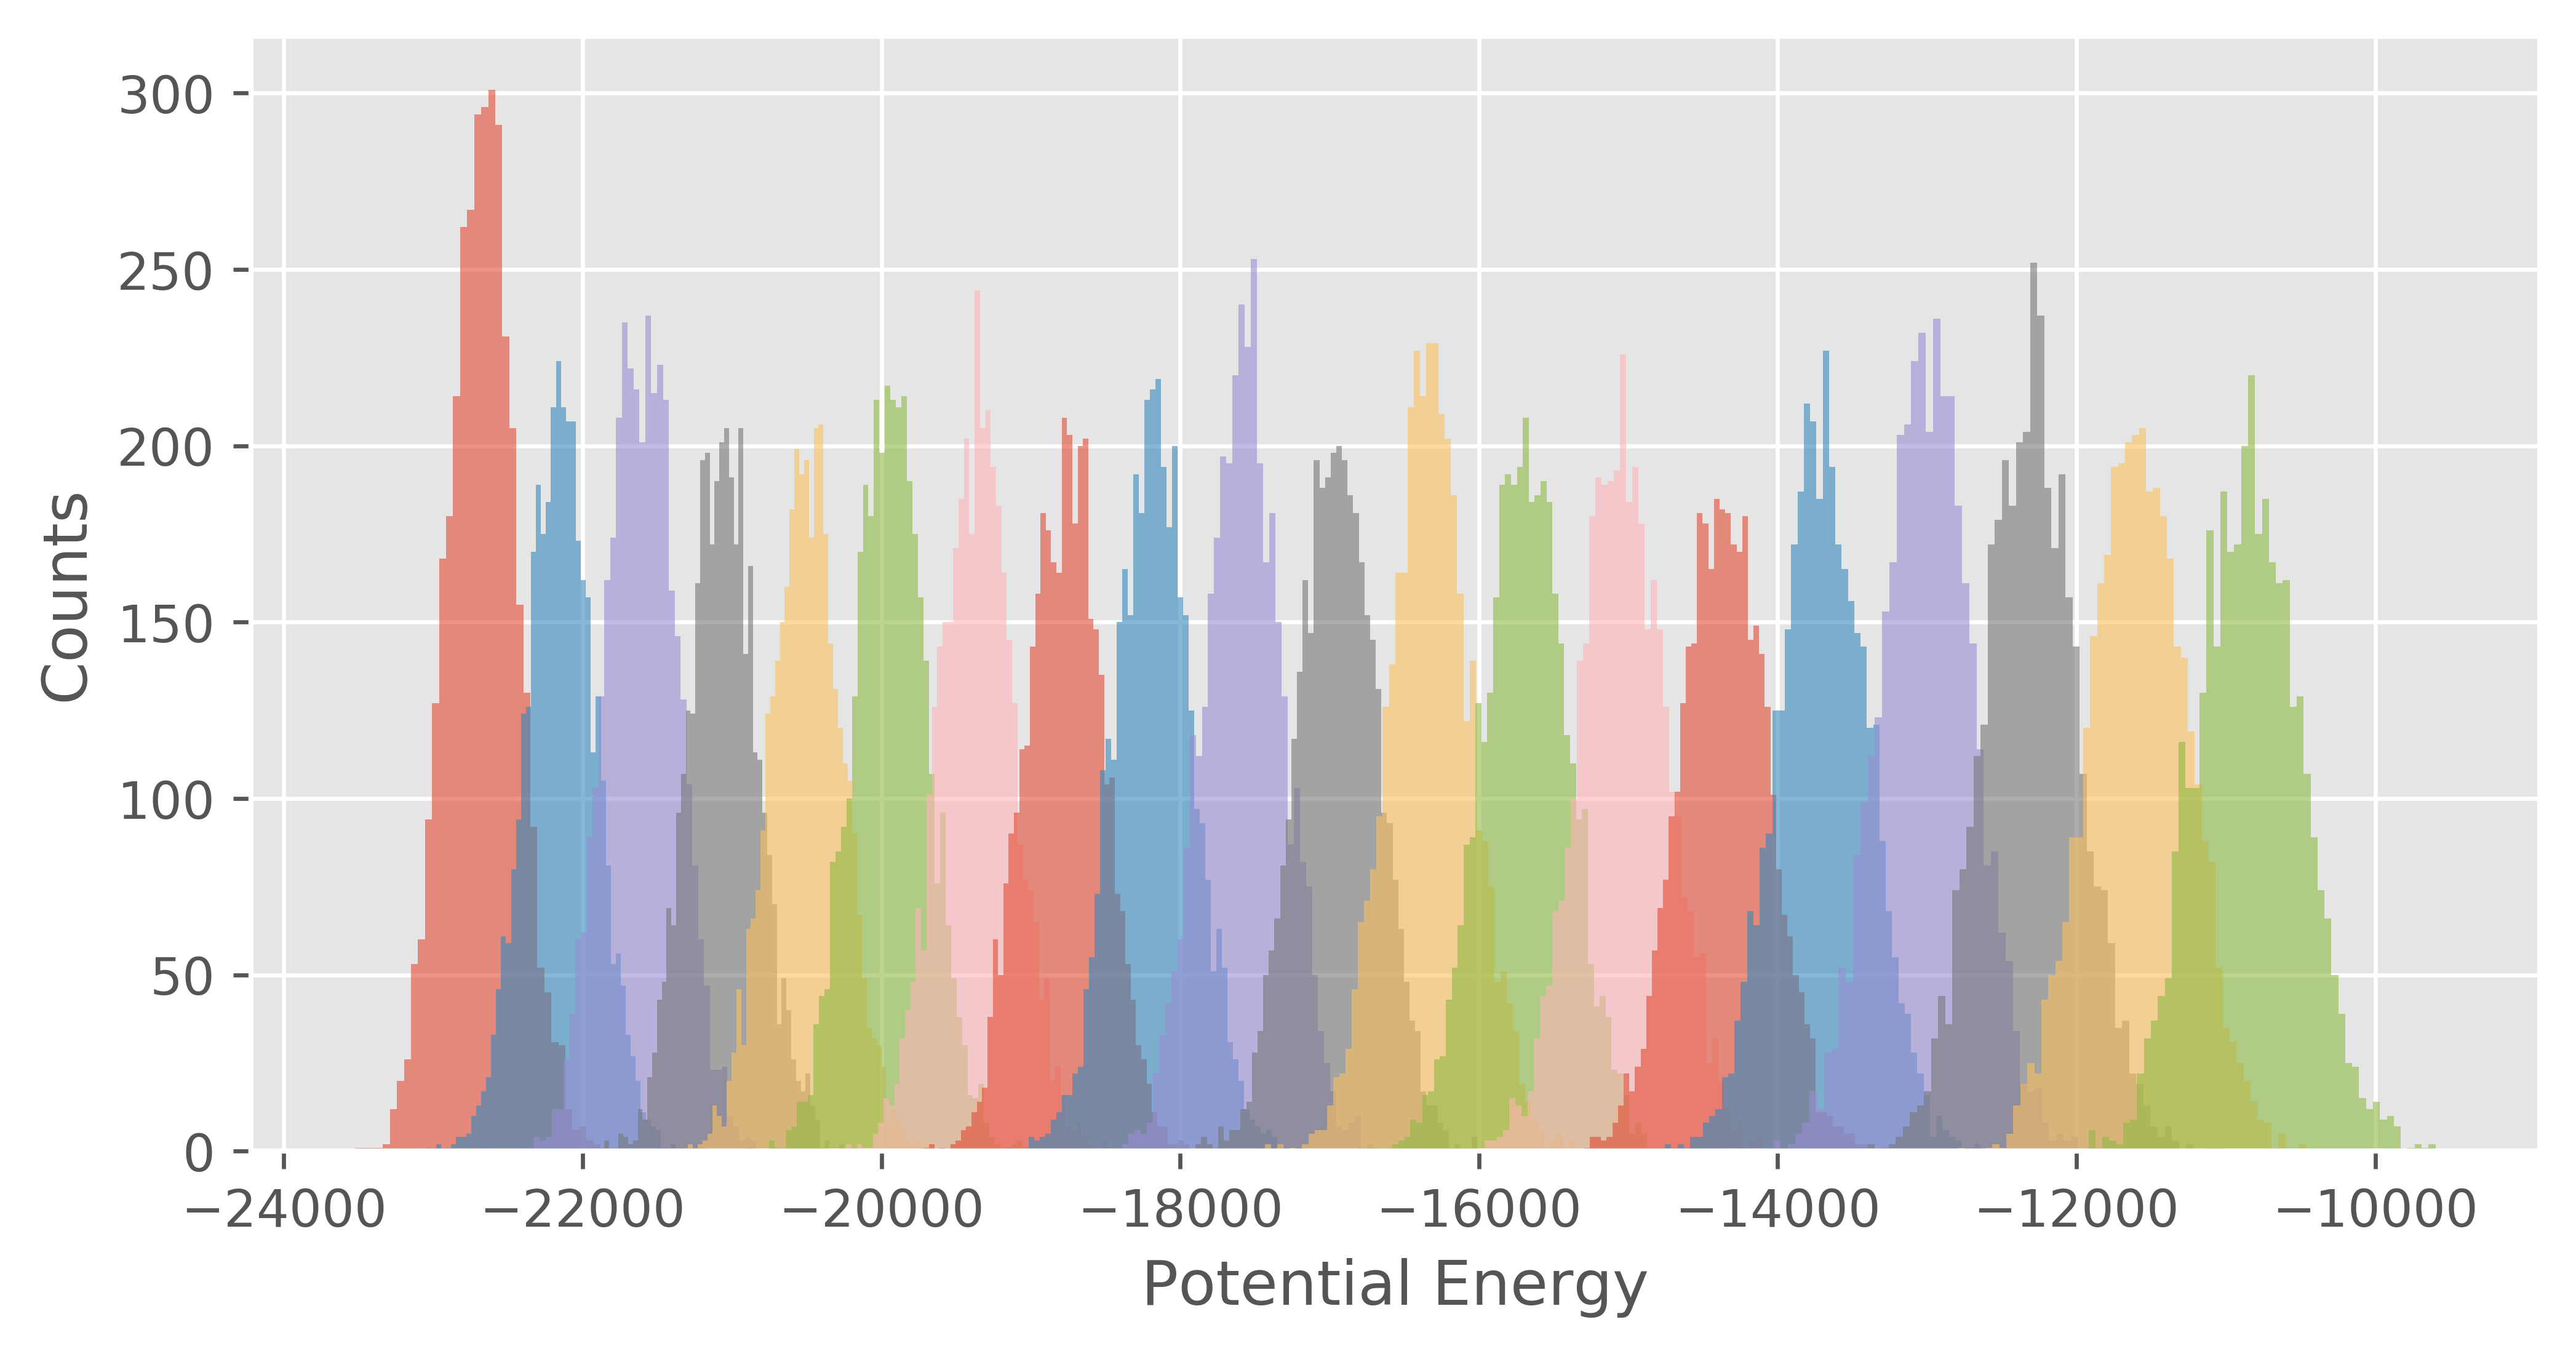

In [5]:
plt.figure(figsize=[8,4], dpi=600)
for i in range(len(temps)):
    # requires cutting off outlier (likely initial frame)
    plt.hist(energies[i][energies[i] > np.min(energies[i])], bins = 50, alpha = 0.6)
    plt.xlabel("Potential Energy")
    plt.ylabel("Counts")
# plt.legend([str(np.round(t, 1)) for t in temps])

In [6]:
for i in range(len(temps) - 1):
    print(1/np.array(temps[i]) - 1/np.array(temps[i + 1]))

8.51904480296357e-05
8.355753023164998e-05
8.19559119583967e-05
8.038499326525235e-05
7.884418570724971e-05
7.73329121186413e-05
7.585060639670382e-05
7.439671328969815e-05
7.297068818885345e-05
7.157199692439057e-05
7.020011556540867e-05
6.885453022363944e-05
6.753473686095003e-05
6.624024110053186e-05
6.4970558041718e-05
6.372521207834939e-05
6.250373672060834e-05
6.130567442028849e-05
6.013057639939765e-05


## Heat Capacity Curve

The nice thing about replica exchange simulations is we can compute the change of a systems heat capacity with temperature.This is especially useful for systems that experience large surface area changes during phase transistions, such as protein folding or melting transitions.

We'll be implementing heat capacity equation, using enthalpy:

$$C_p = \frac{d<H>}{dT}$$

We'll be calculating expectation enthalpy derivatives using MBAR.

In [7]:
find("avogadro")

['Avogadro constant']

In [8]:
kb = physical_constants["Boltzmann constant"][0] *  physical_constants["Avogadro constant"][0] / 1000 # J (molK)^-1

In [9]:
# Initialize MBAR inputs
K = len(temps) # number of states
n_samples = len(energies[0]) # number of samples from each state
betas = 1 / kb / np.array(temps)

u_kln = np.zeros([K, K, n_samples], np.float64)
E_kn = np.zeros([K , n_samples], np.float64)

for k in range(K):
    for l in range(K):
        u_kln[k,l,:] = betas[l] * energies[k]
        

In [10]:
# MBAR
import pymbar
mbar = pymbar.MBAR(u_kln, np.array([n_samples]*K), verbose = True, relative_tolerance = 1e-10, initial_f_k= None, maximum_iterations=1000)

K (total states) = 20, total samples = 73500
N_k = 
[3675 3675 3675 3675 3675 3675 3675 3675 3675 3675 3675 3675 3675 3675
 3675 3675 3675 3675 3675 3675]
There are 20 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Determining dimensionless free energies by Newton-Raphson / self-consistent iteration.
self consistent iteration gradient norm is 5.0206e+09, Newton-Raphson gradient norm is 5.1321e+09
Choosing self-consistent iteration on iteration 0
self consistent iteration gradient norm is 4.7795e+09, Newton-Raphson gradient norm is 5.1321e+09
Choosing self-consistent iteration for lower gradient on iteration 1
self consistent iteration gradient norm is 4.5606e+09, Newton-Raphson gradient norm is 5.1321e+09
Choosing self-consistent iteration for lower gradient on iteration 2
self consistent iteration gradient norm is  4.367e+09, Newton-Raphson gradient norm

In [15]:
# Building potential energy kln matrix
E_kln = u_kln
for k in range(K):
    E_kln[:,k,:] *= betas[k]**(-1)

# mean and variance of energy
E_expected = results['mu']
dE_exoected = results['sigma']

In [ ]:
# mean and variance of difference of energies
results = mbar.computeExpectations(E_kln, output='differences', state_dependent=True, return_dict=True)
DeltaE_expected = results['mu']
dDeltaE_expected = 